In [9]:
!pip install --upgrade --force-reinstall numpy==1.26.4 pandas==2.2.2 gensim implicit

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached implicit-0.7.2-cp312-cp312-linux_x86_64.whl
  Using cached scipy-1.13.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 70.6 MB/s eta 0:00:00
Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 25.9 MB/s eta 0:00:00
Using cached scipy-1.13.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.2 MB)
   ━━━━━━━━━━━━━━━━━━━

In [1]:
import sys
try:
    import gensim
    import implicit
except Exception:
    # Install only missing heavy libs (will restart runtime only if necessary in some envs,
    # but this is minimal and typical for Colab it's fine)
    !pip install --quiet gensim implicit
    import importlib
    importlib.invalidate_caches()

# Optional: seaborn for nicer plots
try:
    import seaborn as sns
    sns_available = True
except Exception:
    sns_available = False


/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-k7_pxbwj/implicit_e42bde62ae3f4ffcabba404aa3dd8703/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares

In [3]:
# -----------------------------------------------------------
# Config (ubah path jika perlu)
# -----------------------------------------------------------
DRIVE_PATHS_TO_TRY = [
    "/content/drive/My Drive/amazon.csv"
]

# -----------------------------------------------------------
# Mount Drive (Colab). Jika tidak pakai Colab, skip ini.
# -----------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    # not running in Colab or mount failed; proceed (user may run locally)
    pass


Mounted at /content/drive


In [4]:
# -----------------------------------------------------------
# Load dataset (cari path yang tersedia)
# -----------------------------------------------------------
df = None
for p in DRIVE_PATHS_TO_TRY:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Loaded dataset from: {p}")
        break

if df is None:
    raise FileNotFoundError(
        "File not found. Please upload 'amazon.csv' to Colab Drive or set the correct path in DRIVE_PATHS_TO_TRY."
    )

print("Initial dataframe shape:", df.shape)
print(df.columns.tolist())
print(df.head(3))


Loaded dataset from: /content/drive/My Drive/amazon.csv
Initial dataframe shape: (1465, 16)
['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.


Missing counts:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64
After dropping rows with missing about_product/rating: (1465, 16)
After cleaning rating: (1464, 16)
Rating dtype: float64


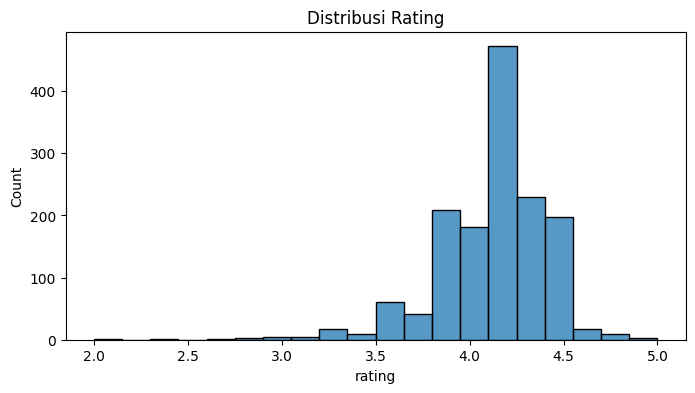

In [5]:
# -----------------------------------------------------------
# Quick checks & missing values
# -----------------------------------------------------------
print("\nMissing counts:")
print(df.isnull().sum())

# -----------------------------------------------------------
# Data cleaning: ensure about_product and rating exist
# -----------------------------------------------------------
if 'about_product' not in df.columns:
    # Fallback: if there's no 'about_product', try 'product_description' or use product_name as text
    fallback_cols = [c for c in ['product_description', 'description', 'product_info', 'product_details'] if c in df.columns]
    if fallback_cols:
        df['about_product'] = df[fallback_cols[0]].astype(str)
    else:
        # fallback to product_name
        df['about_product'] = df['product_name'].astype(str)

# Drop rows missing essential columns
df = df.dropna(subset=['about_product', 'rating']).copy()
print("After dropping rows with missing about_product/rating:", df.shape)

# -----------------------------------------------------------
# Clean rating column: extract numeric part (e.g., "4.0 out of 5" => 4.0)
# -----------------------------------------------------------
df['rating'] = df['rating'].astype(str).str.extract(r'(\d+(\.\d+)?)')[0]
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating']).copy()
df['rating'] = df['rating'].astype(float)
print("After cleaning rating:", df.shape)
print("Rating dtype:", df['rating'].dtype)

# Optional: visualize distribution
if sns_available:
    plt.figure(figsize=(8,4))
    sns.histplot(df['rating'], bins=20)
    plt.title("Distribusi Rating")
    plt.show()
else:
    plt.figure(figsize=(8,4))
    plt.hist(df['rating'].dropna(), bins=20)
    plt.title("Distribusi Rating")
    plt.show()

In [17]:
# -----------------------------------------------------------
# CONTENT-BASED (Word2Vec)
# -----------------------------------------------------------
print("\n=== Content-Based: Word2Vec ===")

# Tokenize descriptions (simple). You may replace with better tokenizer (spacy, nltk).
def tokenize_text(text):
    # keep words only, lowercased
    return re.findall(r'\w+', str(text).lower())

df['tokens'] = df['about_product'].apply(tokenize_text)

# Train Word2Vec on tokens (if dataset small, set min_count=1)
w2v_model = Word2Vec(
    sentences=df['tokens'].tolist(),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    seed=42
)

# compute product vector = mean(word vectors)
def product_vector(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    if not vecs:
        return np.zeros(w2v_model.vector_size, dtype=float)
    return np.mean(vecs, axis=0)

df['vector'] = df['tokens'].apply(product_vector)
product_embeddings = np.vstack(df['vector'].values)  # shape: (n_products, dim)
print("Product embeddings shape:", product_embeddings.shape)

# cosine similarity (careful: large N => heavy)
# We compute similarity on demand inside function to avoid huge memory if dataset big.
def content_based_recommendations(product_title, top_k=5):
    if product_title not in df['product_name'].values:
        return []
    idx = df.index[df['product_name'] == product_title][0]
    v = product_embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(v, product_embeddings)[0]
    order = sims.argsort()[::-1]
    # skip itself
    order = [i for i in order if i != idx]
    top_idx = order[:top_k]
    return df.iloc[top_idx][['product_name', 'rating']]

# Quick example (guard for empty product_name)
if 'product_name' in df.columns and not df['product_name'].isnull().all():
    example_prod = df['product_name'].iloc[0]
    print("Example content-based recommendations for:", example_prod)
    print(content_based_recommendations(example_prod, top_k=5))
else:
    print("No 'product_name' column present -- skip CB example")



=== Content-Based: Word2Vec ===
Product embeddings shape: (1464, 100)
Example content-based recommendations for: Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)
                                          product_name  rating
369  Wayona Nylon Braided USB to Lightning Fast Cha...     4.2
614  Wayona Nylon Braided USB to Lightning Fast Cha...     4.2
220  Wayona Nylon Braided Usb Syncing And Charging ...     4.2
80   Wayona Usb Nylon Braided Data Sync And Chargin...     4.2
430  USB Charger, Oraimo Elite Dual Port 5V/2.4A Wa...     4.0


Example content-based recommendations for: Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)
                                          product_name  rating
369  Wayona Nylon Braided USB to Lightning Fast Cha...     4.2
614  Wayona Nylon Braided USB to Lightning Fast Cha...     4.2
220  Wayona Nylon Braided Usb Syncing And Charging ...     4.2
80   Wayona Usb Nylon Braided Data Sync And Chargin...     4.2
430  USB Charger, Oraimo Elite Dual Port 5V/2.4A Wa...     4.0


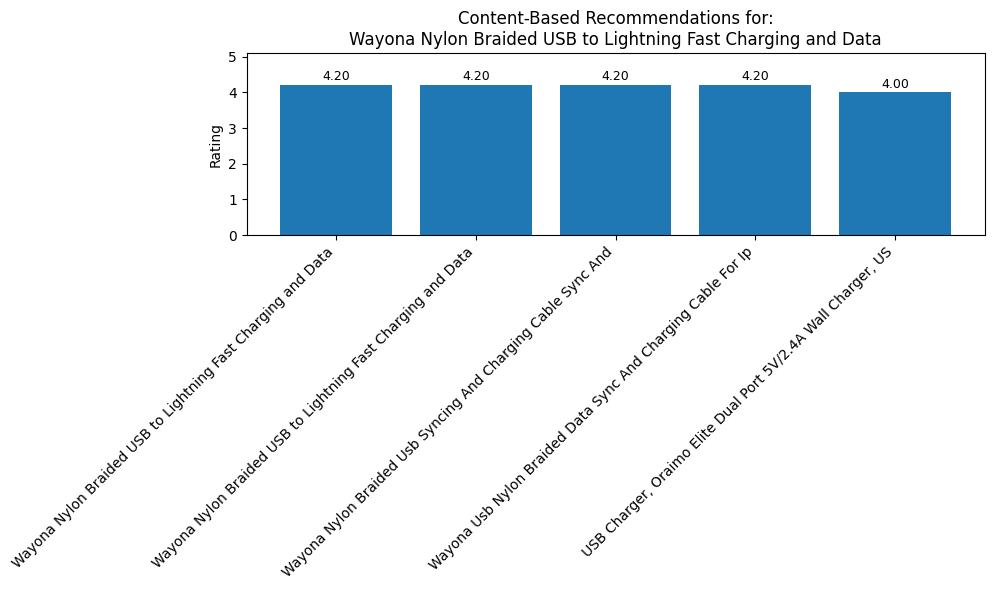

In [19]:
def plot_content_based_recommendations(product_title, top_k=5, figsize=(10,6), truncate=60):
    """
    Plot vertical bar chart untuk rekomendasi Content-Based (Word2Vec).
    - product_title: nama produk acuan
    - top_k: jumlah rekomendasi
    - truncate: potongan panjang nama produk untuk label di x-axis
    """
    recs = content_based_recommendations(product_title, top_k=top_k)
    if isinstance(recs, pd.DataFrame) and not recs.empty:
        recs = recs.copy()
        recs['label'] = recs['product_name'].str.slice(0, truncate).str.rstrip()

        plt.figure(figsize=figsize)
        bars = plt.bar(range(len(recs)), recs['rating'])
        plt.xticks(range(len(recs)), recs['label'], rotation=45, ha='right')
        plt.ylabel('Rating')
        plt.ylim(0, 5.1)
        plt.title(f'Content-Based Recommendations for:\n{product_title[:truncate]}')

        # tambahkan angka rating di atas bar
        for i, v in enumerate(recs['rating'].values):
            plt.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()
    else:
        print(f"No content-based recommendations found for: {product_title}")

# Contoh pemanggilan
example_prod = df['product_name'].iloc[0]
print("Example content-based recommendations for:", example_prod)
print(content_based_recommendations(example_prod, top_k=5))
plot_content_based_recommendations(example_prod, top_k=5)


In [10]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"


In [11]:
# -----------------------------------------------------------
# COLLABORATIVE FILTERING: ALS (implicit)
# -----------------------------------------------------------
print("\n=== Collaborative Filtering: ALS (implicit) ===")

# Ensure user_id and product_name exist
if 'user_id' not in df.columns or 'product_name' not in df.columns:
    raise KeyError("Dataset must contain 'user_id' and 'product_name' columns for collaborative filtering.")

# encode user and item to integer codes
df['user_code'] = df['user_id'].astype('category').cat.codes.astype(int)
df['item_code'] = df['product_name'].astype('category').cat.codes.astype(int)

# ensure numeric
df['user_code'] = df['user_code'].astype(int)
df['item_code'] = df['item_code'].astype(int)
df['rating'] = df['rating'].astype(float)

# build sparse matrix (users x items)
ratings_matrix = coo_matrix(
    (df['rating'].values, (df['user_code'].values, df['item_code'].values))
)
print("Ratings matrix shape (users x items):", ratings_matrix.shape)

# Train ALS model (implicit expects item-user matrix for fit)
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, use_gpu=False)
# fit takes item_users matrix
als_model.fit(ratings_matrix.T)

# mapping helpers
user_code_to_id = dict(enumerate(df['user_id'].astype('category').cat.categories))
item_code_to_name = dict(enumerate(df['product_name'].astype('category').cat.categories))
# reverse maps (if needed)
user_id_to_code = {v: k for k, v in user_code_to_id.items()}

def als_recommend(user_id, top_k=5):
    """
    Robust ALS recommend wrapper:
    - menangani keluaran recommend() yang bisa berupa list of tuples
      atau tuple of arrays.
    - mengembalikan list nama produk.
    """
    if user_id not in user_id_to_code:
        return []

    ucode = user_id_to_code[user_id]
    user_items = ratings_matrix.tocsr()[ucode]

    # panggil recommend
    recs = als_model.recommend(ucode, user_items, N=top_k)

    # normalisasi ke list of (item_code, score)
    rec_list = []

    # Kasus 1: recommend mengembalikan tuple (ids_array, scores_array)
    if isinstance(recs, tuple) and len(recs) == 2:
        ids, scores = recs
        rec_list = [(int(i), float(s)) for i, s in zip(ids, scores)]

    else:
        # Kasus 2: recommend mengembalikan iterable (mis. list of (id, score))
        try:
            for entry in recs:
                # entry bisa berupa array/tuple seperti [id, score]
                if hasattr(entry, '__len__') and len(entry) >= 2:
                    rec_list.append((int(entry[0]), float(entry[1])))
                else:
                    # entry hanya id saja
                    rec_list.append((int(entry), None))
        except Exception:
            # fallback: konversi numpy array dua dimensi
            import numpy as _np
            arr = _np.asarray(recs)
            if arr.ndim == 2 and arr.shape[1] >= 2:
                rec_list = [(int(x[0]), float(x[1])) for x in arr]
            else:
                rec_list = [(int(x), None) for x in arr.ravel()]

    # ambil nama produk dari kode item
    rec_names = []
    for item_code, score in rec_list:
        name = item_code_to_name.get(item_code, None)
        if name is not None:
            rec_names.append((name, score))
        else:
            # jika mapping tidak ada, masukkan kode saja
            rec_names.append((f"<item_code:{item_code}>", score))

    return rec_names

# Example ALS recommendation
example_user = df['user_id'].iloc[0]
print("ALS recommendations (name, score):", als_recommend(example_user, top_k=5))
print(als_recommend(example_user, top_k=5))


=== Collaborative Filtering: ALS (implicit) ===
Ratings matrix shape (users x items): (1193, 1336)


/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0003368854522705078 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

ALS recommendations (name, score): [('Redmi Note 11T 5G (Stardust White, 6GB RAM, 128GB ROM)| Dimensity 810 5G | 33W Pro Fast Charging | Charger Included | Additional Exchange Offers|Get 2 Months of YouTube Premium Free!', 0.12192855775356293), ('MYVN LTG to USB for\xa0Fast Charging & Data Sync USB Cable Compatible for iPhone 5/5s/6/6S/7/7+/8/8+/10/11, iPad Air/Mini, iPod and iOS Devices (1 M)', 0.11130676418542862), ('Acer 80 cm (32 inches) N Series HD Ready TV AR32NSV53HD (Black)', 0.10981778055429459), ('BRUSTRO Copytinta Coloured Craft Paper A4 Size 80 GSM Mixed Bright Colour 40 Sheets Pack (10 cols X 4 Sheets) Double Side Color for Office Printing, Art and Craft.', 0.08494199812412262), ('Sujata Powermatic Plus, Juicer Mixer Grinder with Chutney Jar, 900 Watts, 3 Jars (White)', 0.07961798459291458)]
[('Redmi Note 11T 5G (Stardust White, 6GB RAM, 128GB ROM)| Dimensity 810 5G | 33W Pro Fast Charging | Charger Included | Additional Exchange Offers|Get 2 Months of YouTube Premium Free

ALS recommendations (name, score): [('Redmi Note 11T 5G (Stardust White, 6GB RAM, 128GB ROM)| Dimensity 810 5G | 33W Pro Fast Charging | Charger Included | Additional Exchange Offers|Get 2 Months of YouTube Premium Free!', 0.12192855775356293), ('MYVN LTG to USB for\xa0Fast Charging & Data Sync USB Cable Compatible for iPhone 5/5s/6/6S/7/7+/8/8+/10/11, iPad Air/Mini, iPod and iOS Devices (1 M)', 0.11130676418542862), ('Acer 80 cm (32 inches) N Series HD Ready TV AR32NSV53HD (Black)', 0.10981778055429459), ('BRUSTRO Copytinta Coloured Craft Paper A4 Size 80 GSM Mixed Bright Colour 40 Sheets Pack (10 cols X 4 Sheets) Double Side Color for Office Printing, Art and Craft.', 0.08494199812412262), ('Sujata Powermatic Plus, Juicer Mixer Grinder with Chutney Jar, 900 Watts, 3 Jars (White)', 0.07961798459291458)]


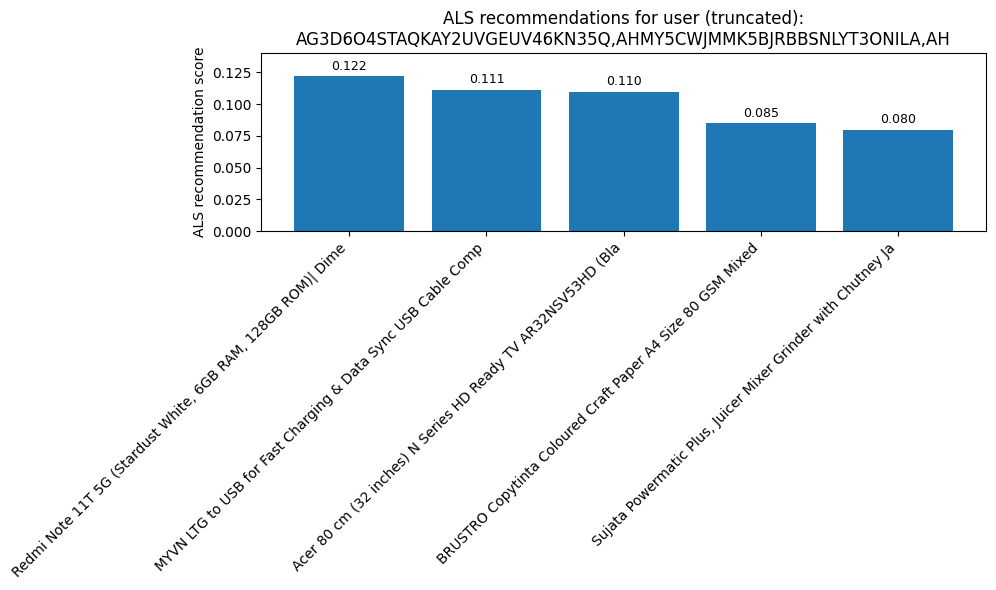

In [13]:
def plot_als_recommendations(user_id, top_k=5, figsize=(10,6), truncate=60):
    """
    Plot vertical bar chart of ALS recommendations for a given user_id.
    - user_id: user identifier (string) as in df['user_id']
    - top_k: number of recommendations
    - truncate: character limit for product labels displayed on x-axis
    """
    recs = als_recommend(user_id, top_k=top_k)
    if not recs:
        print(f"No ALS recommendations found for user_id: {user_id}")
        return

    # Build DataFrame
    rec_df = pd.DataFrame(recs, columns=['product_name', 'score'])
    # Replace None scores with 0 for plotting (or keep NaN and handle)
    rec_df['score'] = rec_df['score'].fillna(0.0).astype(float)
    # sort by score descending
    rec_df = rec_df.sort_values(by='score', ascending=False).reset_index(drop=True)
    rec_df['label'] = rec_df['product_name'].str.slice(0, truncate).str.rstrip()

    # plot
    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(rec_df)), rec_df['score'])
    plt.xticks(range(len(rec_df)), rec_df['label'], rotation=45, ha='right')
    plt.ylabel('ALS recommendation score')
    # set y-limits a bit above max score for annotation space
    ymax = rec_df['score'].max() * 1.15 if rec_df['score'].max() > 0 else 1.0
    plt.ylim(0, ymax)
    plt.title(f'ALS recommendations for user (truncated):\n{str(user_id)[:truncate]}')
    # annotate values above bars
    for i, v in enumerate(rec_df['score'].values):
        plt.text(i, v + (ymax * 0.02), f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

# Example ALS recommendation + plot
example_user = df['user_id'].iloc[0]
print("ALS recommendations (name, score):", als_recommend(example_user, top_k=5))
plot_als_recommendations(example_user, top_k=5)


=== Evaluation & Summary ===
Top 5 products by mean rating:
 product_name
Amazon Basics Wireless Mouse | 2.4 GHz Connection, 1600 DPI | Type - C Adapter | Upto 12 Months of Battery Life | Ambidextrous Design | Suitable for PC/Mac/Laptop                               5.0
Syncwire LTG to USB Cable for Fast Charging Compatible with Phone 5/ 5C/ 5S/ 6/ 6S/ 7/8/ X/XR/XS Max/ 11/12/ 13 Series and Pad Air/Mini, Pod & Other Devices (1.1 Meter, White)                  5.0
REDTECH USB-C to Lightning Cable 3.3FT, [Apple MFi Certified] Lightning to Type C Fast Charging Cord Compatible with iPhone 14/13/13 pro/Max/12/11/X/XS/XR/8, Supports Power Delivery - White    5.0
Instant Pot Air Fryer, Vortex 2QT, Touch Control Panel, 360° EvenCrisp™ Technology, Uses 95 % less Oil, 4-in-1 Appliance: Air Fry, Roast, Bake, Reheat (Vortex 1.97Litre, Black)                 4.8
Swiffer Instant Electric Water Heater Faucet Tap Home-Kitchen Instantaneous Water Heater Tank less for Tap, LED Electric Head Water Heate

/tmp/ipython-input-1942193203.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


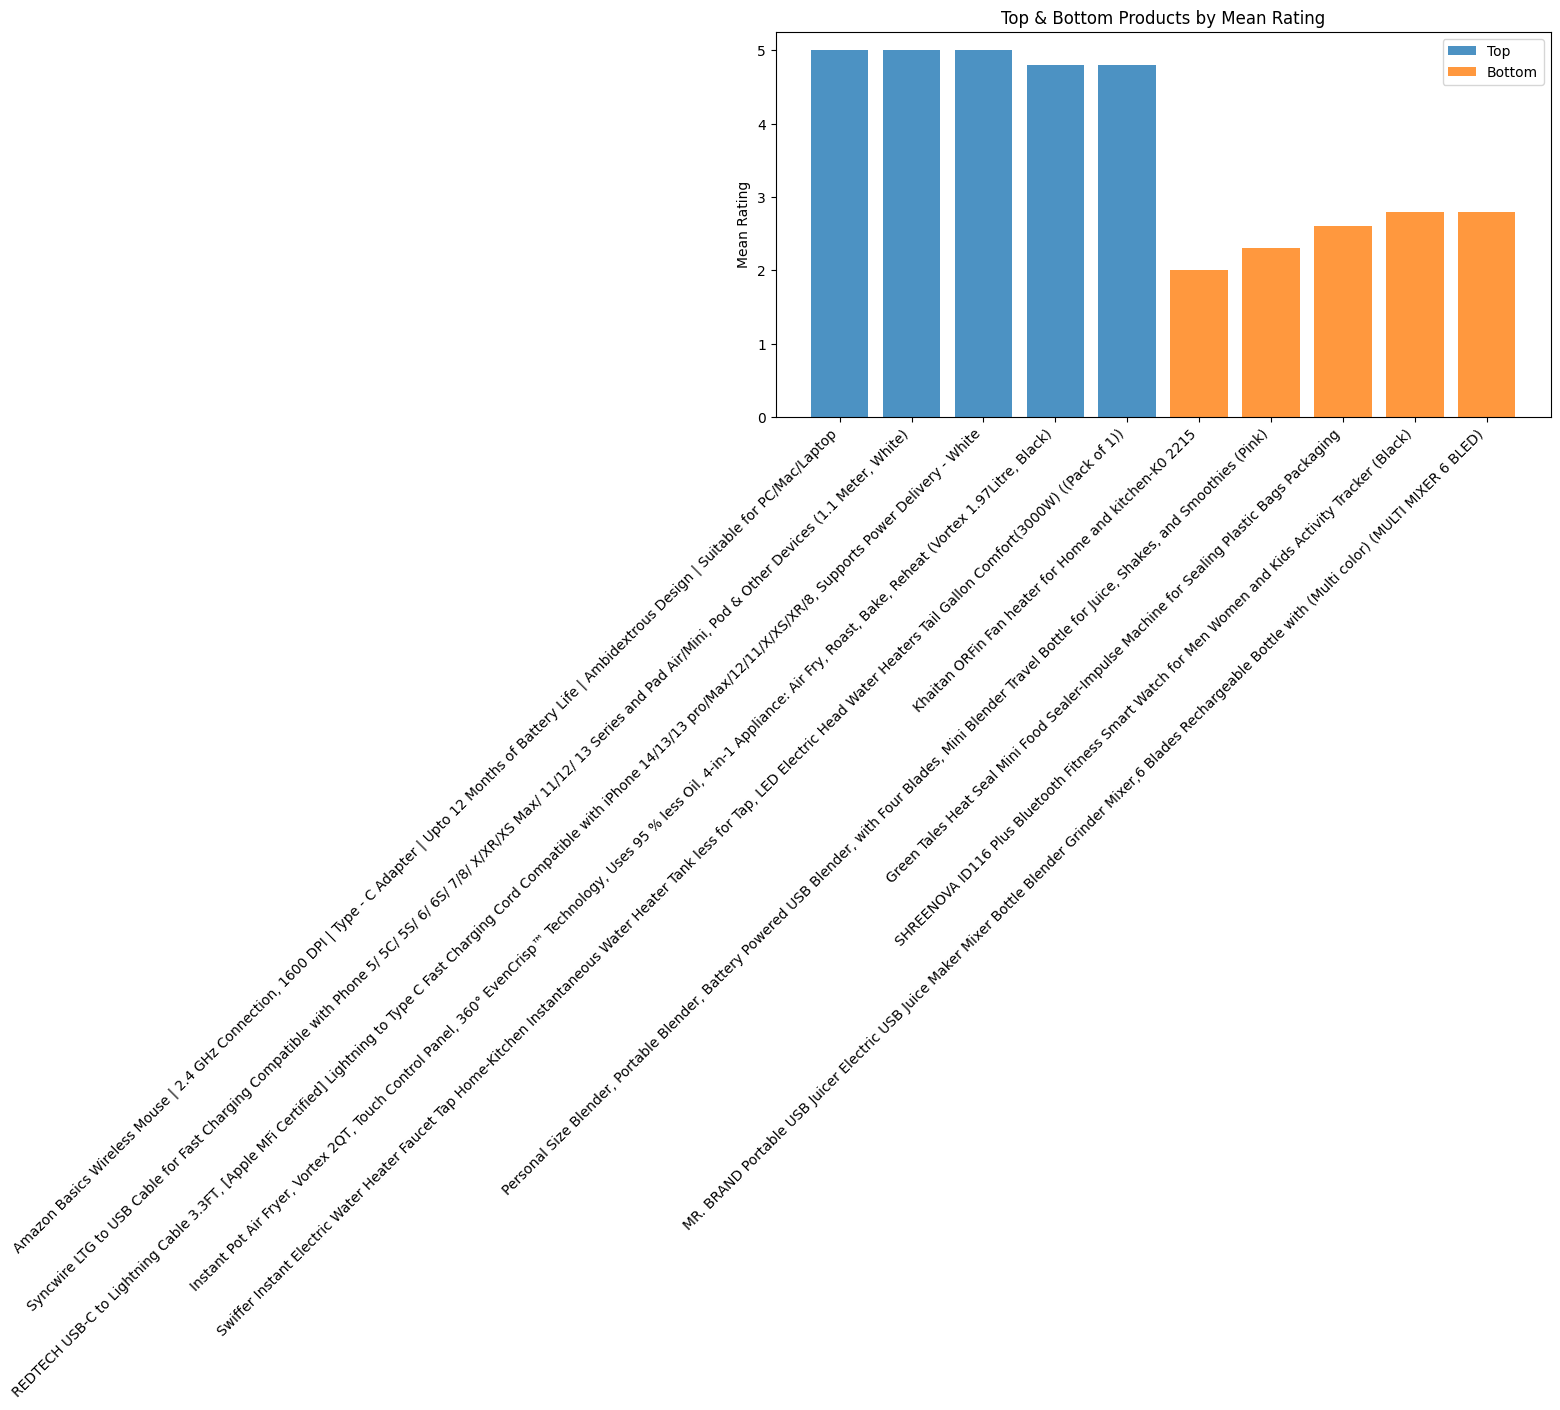

In [14]:
# -----------------------------------------------------------
# Simple evaluation & top/bottom products
# -----------------------------------------------------------
print("\n=== Evaluation & Summary ===")
top_products = df.groupby('product_name')['rating'].mean().sort_values(ascending=False).head(5)
bottom_products = df.groupby('product_name')['rating'].mean().sort_values(ascending=True).head(5)
print("Top 5 products by mean rating:\n", top_products)
print("Bottom 5 products by mean rating:\n", bottom_products)

# Plot top/bottom (optional)
plt.figure(figsize=(10,5))
plt.bar(top_products.index, top_products.values, label='Top', alpha=0.8)
plt.bar(bottom_products.index, bottom_products.values, label='Bottom', alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Rating')
plt.title('Top & Bottom Products by Mean Rating')
plt.legend()
plt.tight_layout()
plt.show()


Hybrid recommendations:
[('MYVN LTG to USB for\xa0Fast Charging & Data Sync USB Cable Compatible for iPhone 5/5s/6/6S/7/7+/8/8+/10/11, iPad Air/Mini, iPod and iOS Devices (1 M)', 0.5441034622490406), ('Acer 80 cm (32 inches) N Series HD Ready TV AR32NSV53HD (Black)', 0.5423405058681965), ('Brayden Chopro, Electric Vegetable Chopper for Kitchen with 500 ML Capacity, 400 Watts Copper Motor and 4 Bi-Level SS Blades (Black)', 0.5314402878284454), ('Amazon Basics USB 3.0 Cable - A Male to Micro B - 6 Feet (1.8 Meters), Black', 0.5304793827235699), ('VU 164 cm (65 inches) The GloLED Series 4K Smart LED Google TV 65GloLED (Grey)', 0.5250517129898071)]


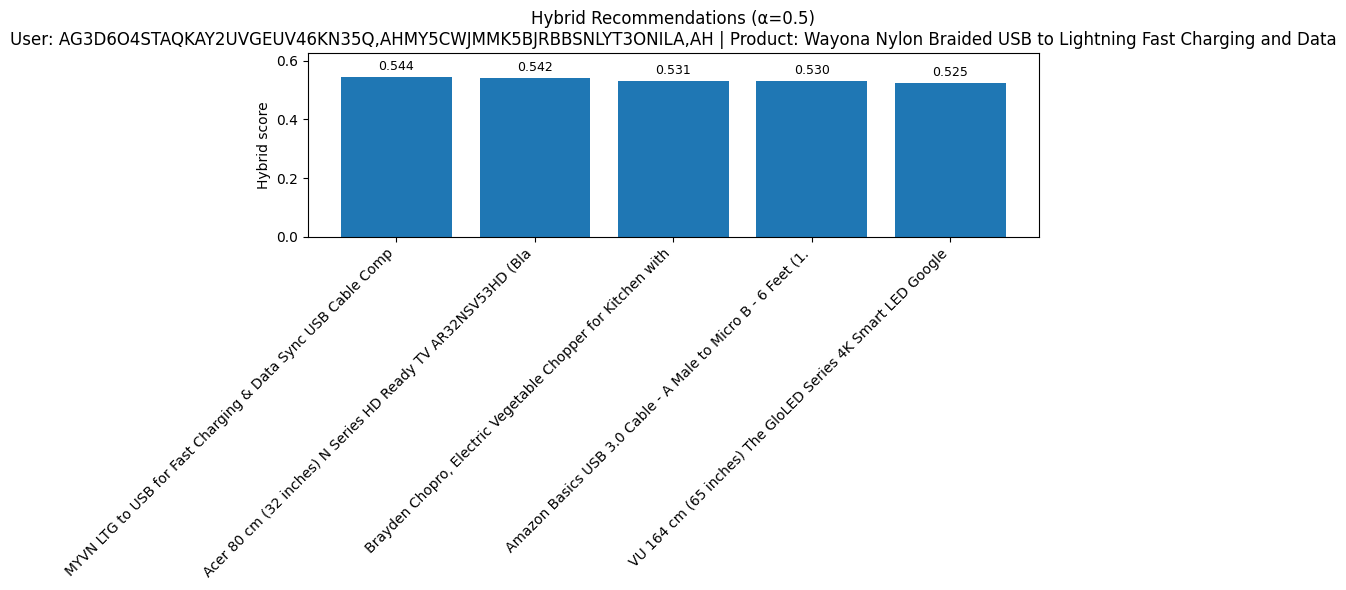

In [22]:
def hybrid_recommend(user_id, product_title, top_k=5, alpha=0.5):
    """
    Hybrid recommendation = kombinasi Content-Based (Word2Vec) + Collaborative Filtering (ALS).
    - alpha: bobot 0–1. Semakin tinggi alpha, semakin dominan content-based.
    """
    # CBF similarity scores
    if product_title not in df['product_name'].values:
        return []
    idx = df.index[df['product_name'] == product_title][0]
    v = product_embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(v, product_embeddings)[0]

    # ALS scores
    if user_id not in user_id_to_code:
        return []
    ucode = user_id_to_code[user_id]
    user_items = ratings_matrix.tocsr()[ucode]
    als_ids, als_scores = als_model.recommend(ucode, user_items, N=len(item_code_to_name))

    # Buat dict ALS score
    als_dict = {int(i): float(s) for i, s in zip(als_ids, als_scores)}

    # Gabungkan skor
    hybrid_scores = []
    for item_code, name in item_code_to_name.items():
        sim_score = sims[item_code] if item_code < len(sims) else 0
        als_score = als_dict.get(item_code, 0)
        final_score = alpha * sim_score + (1 - alpha) * als_score
        hybrid_scores.append((name, final_score))

    # Urutkan dan ambil top_k
    hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)
    return hybrid_scores[:top_k]


def plot_hybrid_recommendations(user_id, product_title, top_k=5, alpha=0.5, figsize=(10,6), truncate=60):
    """
    Plot vertical bar chart untuk hasil Hybrid Recommendation.
    """
    recs = hybrid_recommend(user_id, product_title, top_k=top_k, alpha=alpha)
    if not recs:
        print("Tidak ada hasil rekomendasi hybrid.")
        return

    rec_df = pd.DataFrame(recs, columns=['product_name', 'score'])
    rec_df['label'] = rec_df['product_name'].str.slice(0, truncate).str.rstrip()

    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(rec_df)), rec_df['score'])
    plt.xticks(range(len(rec_df)), rec_df['label'], rotation=45, ha='right')
    plt.ylabel('Hybrid score')
    ymax = rec_df['score'].max() * 1.15 if rec_df['score'].max() > 0 else 1.0
    plt.ylim(0, ymax)
    plt.title(f'Hybrid Recommendations (α={alpha})\nUser: {str(user_id)[:truncate]} | Product: {product_title[:truncate]}')

    # Tambahkan nilai di atas bar
    for i, v in enumerate(rec_df['score'].values):
        plt.text(i, v + (ymax * 0.02), f"{v:.3f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


# Contoh pemanggilan
example_user = df['user_id'].iloc[0]
example_prod = df['product_name'].iloc[0]

print("Hybrid recommendations:")
print(hybrid_recommend(example_user, example_prod, top_k=5, alpha=0.5))
plot_hybrid_recommendations(example_user, example_prod, top_k=5, alpha=0.5)
